Sunspot Dataset

In [ ]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
# plot command

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)



2.3.0


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

import numpy as np
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
#plt.figure(figsize=(10, 6))
#plot_series(time, series)


# split_time is setting up the train / split

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

--2020-11-11 00:03:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.164.176, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-11-11 00:03:53 (121 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Format Windowed Data & Build Dense Model

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Dense(20,input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-7,momentum=0.9))
history = model.fit(dataset,epochs=20)

### Creating a Time Series dataset Windowing & Batching

In [ ]:
# shuffling prevents the net from getting stuck in local minima

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


# put into tf format
temp = tf.data.Dataset.from_tensor_slices(series)
# this just sets up the dimension of the window
# want 30+1 because eventually that 1 will be split into the response 
#   for the previous 30
# shift by 1 because we are using 30 previous points to predict the next one
temp = temp.window(window_size+1,shift=1,drop_remainder=True)


# each set of 31 here is:
#   1st: first 31 values
#   2nd: shifted forward by one value
temp = temp.flat_map(lambda w: w.batch(window_size+1))
temp = temp.shuffle(shuffle_buffer_size)


# this takes each batch & turns it into a tuple
# the training points are the first 30
# the response is the last number
temp = temp.map(lambda w: (w[:-1], w[:1:]))


# this turns the data into a tuple of 32 batches of 30
# along with 30 responses
# prefetch is a performance thing
temp = temp.batch(batch_size).prefetch(1)
temp


#def sub_to_batch(sub):
#  return sub.batch(window_size, drop_remainder=True)

#for i in temp:
#  for j in i:
#    print(j.numpy())

#for example in temp.take(5):
#  print(example.numpy())




<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float64, tf.float64)>

### Conv1D + LSTM model

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


window_size = 30
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  # since our predictions are in the 1 to 400 range
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.summary()
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
____________________

### Plot Learning Rate & Loss

(1e-08, 0.0001, 0.0, 60.0)

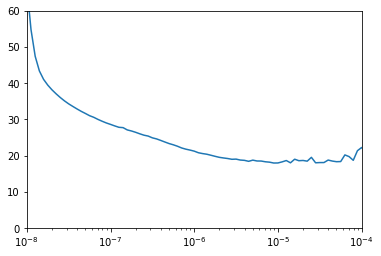

In [ ]:
import matplotlib.pyplot as plt
plt.semilogx(history.history["lr"], history.history["loss"]) 
plt.axis([1e-8, 1e-4, 0, 60])

### Update Model based on learning rate

In [ ]:
# changing window_size, batch_size, filters, & layer sizes

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=32, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)#,
  #tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=60)

Epoch 1/60
93/93 [==============================] - 2s 19ms/step - loss: 82.4822 - mae: 82.9704
Epoch 2/60
93/93 [==============================] - 2s 19ms/step - loss: 82.3575 - mae: 82.8456
Epoch 3/60
93/93 [==============================] - 2s 19ms/step - loss: 82.2480 - mae: 82.7366
Epoch 4/60
93/93 [==============================] - 2s 19ms/step - loss: 82.1674 - mae: 82.6565
Epoch 5/60
93/93 [==============================] - 2s 19ms/step - loss: 82.0957 - mae: 82.5853
Epoch 6/60
93/93 [==============================] - 2s 19ms/step - loss: 82.0240 - mae: 82.5142
Epoch 7/60
93/93 [==============================] - 2s 19ms/step - loss: 81.9511 - mae: 82.4419
Epoch 8/60
93/93 [==============================] - 2s 19ms/step - loss: 81.8755 - mae: 82.3670
Epoch 9/60
93/93 [==============================] - 2s 19ms/step - loss: 81.7913 - mae: 82.2834
Epoch 10/60
93/93 [==============================] - 2s 19ms/step - loss: 81.6998 - mae: 82.1926
Epoch 11/60
93/93 [====================